## Generate the color mask in the patterned sensing

In [ ]:
from google.colab import files
files.upload()

Saving Read_Data_set.py to Read_Data_set.py


{'Read_Data_set.py': b'## generator x\r\n\r\nimport keras\r\nimport numpy as np\r\nimport tensorflow as tf\r\nfrom os.path import join, isfile\r\nimport scipy.io as sio\r\nfrom tensorflow.keras.utils import Sequence\r\n\r\n\r\nclass DataGenerator(Sequence):\r\n\r\n    def __init__(self, list_IDs, flag_tr, D, im_path, dic_img,\r\n                 batch_size=5, dim=(400, 400, 120), shuffle=True, augment=False):\r\n\r\n        # Initialization\r\n        self.dim = dim\r\n        self.batch_size = batch_size\r\n        self.list_IDs = list_IDs\r\n        self.flag_tr = flag_tr\r\n        self.D = D\r\n        self.im_path = im_path\r\n        self.dic_img = dic_img\r\n        self.shuffle = shuffle\r\n        self.augment = augment\r\n        self.on_epoch_end()\r\n\r\n    def __len__(self):\r\n        # number of batches per epoch\r\n        return int(np.floor(len(self.list_IDs) / self.batch_size))\r\n\r\n    def __getitem__(self, index):\r\n        # Generate one batch of data\r\n     

In [ ]:
## Run Deep fusion network
# load libraries

from os import listdir
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from Read_Data_set import *
from scipy.io import loadmat
from scipy.sparse import csr_matrix, find

# parameters of the net
BATCH_SIZE = 1; EPOCHS=1000; IMG_WIDTH = 256; IMG_HEIGHT = 256; L_bands = 31; 

# directory
dataset_path = "/content/drive/My Drive/Cleaned"
dataset_dict = 'rad'
callback_path = './output/'

#---------------------Generator-----------------------------------------------------------------------------------------

# Transformations
D = ImageDataGenerator(rotation_range=180,
                       width_shift_range=0.2, 
                       height_shift_range=0.2,
                       horizontal_flip=True)

params = {'dim': (IMG_WIDTH, IMG_HEIGHT, L_bands),
          'batch_size': BATCH_SIZE,
          'im_path': dataset_path,
          'dic_img': dataset_dict,
          'shuffle': True,
          'augment': False}  # Augmented only for training

HyperFiles = [fn for fn in listdir(dataset_path) if isfile(join(dataset_path, fn)) and fn.lower().endswith(('.mat')) ]

print('Training images: ',len(HyperFiles))

flag_tr=False
train_gen = DataGenerator(HyperFiles, flag_tr, D, **params)

params = {'dim': (IMG_WIDTH, IMG_HEIGHT, L_bands),
          'batch_size': BATCH_SIZE,
          'im_path': dataset_path + '/validation',
          'dic_img': dataset_dict,
          'shuffle': True,
          'augment': False}

HyperFiles = [
        fn  # Create full paths to images
        for fn in listdir(dataset_path + '/validation')
        if isfile(join(dataset_path + '/validation', fn))
           and fn.lower().endswith(('.mat'))
    ]

print('Testing images: ',len(HyperFiles))

flag_tr=False
val_gen = DataGenerator(HyperFiles, flag_tr, D, **params)


#cargar matriz H
path = '/content/drive/My Drive/Colab Notebooks/datasets/H.mat'
H = loadmat(path).get('H')
[row,col,val] = find(H)
ind = np.asarray([row,col])
ind = np.transpose(ind,(1,0))
H_s = tf.SparseTensor(indices=ind,values=val,dense_shape=[H.shape[0],H.shape[1]])

Using TensorFlow backend.


Training images:  165
Testing images:  30


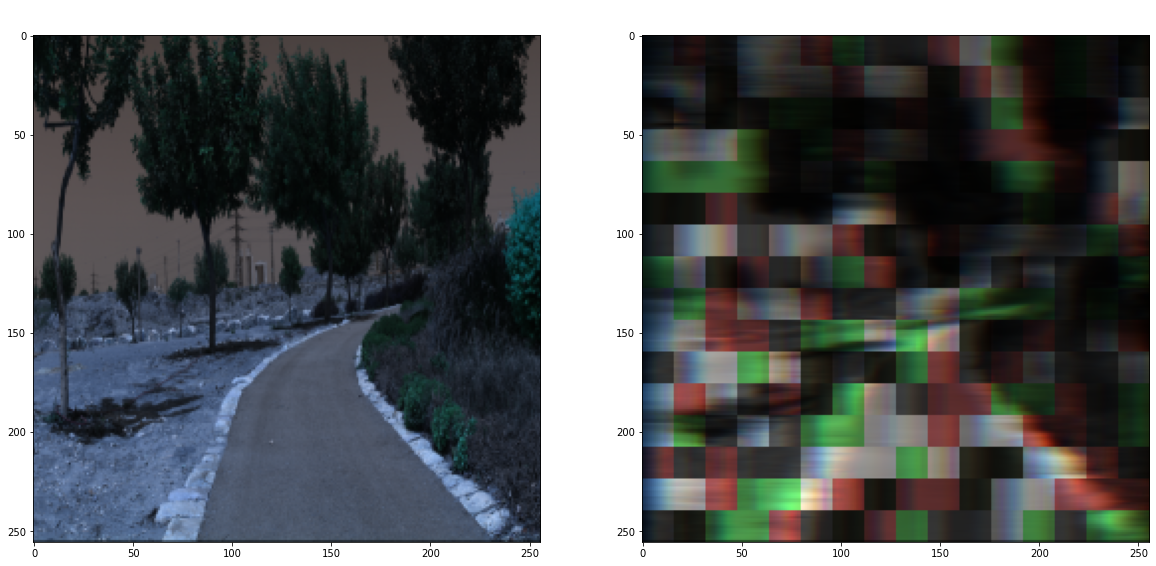

In [ ]:
xx = loadmat('/content/drive/My Drive/Cleaned/BGU_104.mat')
xx = xx['rad']

xx = tf.convert_to_tensor(xx,dtype=tf.float64)
xx = tf.expand_dims(xx,0)
xx = tf.image.resize(xx,(256,256))
xx = xx/tf.math.reduce_max(xx)
xx = xx.numpy()

input = tf.transpose(tf.reshape(xx,(1,31*256*256)),(1,0))
y = tf.sparse.sparse_dense_matmul(H_s, tf.cast(input, dtype=tf.float64))
y = tf.sparse.sparse_dense_matmul(tf.sparse.transpose(H_s), y)
ex = tf.reshape(tf.transpose(y,(1,0)),(1,256,256,31))
ex = ex / tf.math.reduce_max(ex)
ex = ex.numpy()

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['axes.titlesize'] = 26

fig , (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(xx[0][:,:,[10,15,20]])
ax1.set_title('Imágen Original')
ax2.imshow(ex[0][:,:,[10,15,20]])
ax2.set_title('Measurement')

plt.show()

In [ ]:
## Functions to Lambda layers

import tensorflow as tf
import numpy as np

def measurement(input,H,batch):
  ind =batch
  Mn = input.shape[1]
  Nn = input.shape[2]
  L1 = input.shape[3]

  input = tf.transpose(tf.reshape(input,(ind,L1*Mn*Nn)),(1,0))
  y = tf.sparse.sparse_dense_matmul(H, tf.cast(input, dtype=tf.float64))
  y = tf.sparse.sparse_dense_matmul(tf.sparse.transpose(H), y)
  ex = tf.reshape(tf.transpose(y,(1,0)),(ind,Mn,Nn,L1))
  ex = ex / tf.math.reduce_max(ex)
  return ex




## Deep Model


In [ ]:
#u-net 
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy as np
import keras
import scipy.io
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras import backend as Kt

def Deep_Model(input_size=(250, 250, 31), depth =31, H=H_s,batch=32):

    # define the model input
    inputs = Input(shape=input_size)

    layer_R = Lambda(lambda x: measurement(x, H,batch))(inputs)
    #coder

    conv1 = Conv2D(6, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(layer_R) #128x128x6
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(6, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(conv1) #128x128x6

    conv11 = MaxPooling2D(pool_size=(2, 2))(conv1)  #64x64x6

    conv12 = Conv2D(12, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(conv11) #64x64x12
    conv12 = Dropout(0.1)(conv12)
    conv12 = Conv2D(12, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(conv12) #64x64x12

    conv15 = MaxPooling2D(pool_size=(2, 2))(conv12) #32x32x12 cambiar a 5,5

    conv15 = Conv2D(24, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(conv15) #32x32x24
    conv15 = Dropout(0.2)(conv15)
    conv15 = Conv2D(24, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(conv15) #32x32x24

    #125x125
    conv13 = UpSampling2D(size=(2, 2))(conv15) #64x64x24

    conv1312 = Concatenate()([conv13, conv12])  #64x64x36

    conv151 = Conv2D(12, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(conv1312) # 64x64x12
    conv151 = Dropout(0.2)(conv151)
    conv151 = Conv2D(12, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(conv151) # 64x64x12

    #
    # 250x250
    conv1250 = UpSampling2D(size=(2, 2))(conv151) #128X128x12

    conv250 = Concatenate()([conv1250, conv1]) #128x128x18

    conv250 = Conv2D(6, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(conv250) #128x128x6
    conv250 = Dropout(0.1)(conv250)
    conv250 = Conv2D(6, (3, 3), padding="same", kernel_initializer='he_normal', activation="relu")(conv250) #128x128x6

    conv5 = Conv2D(6, (1, 1), padding="same", kernel_initializer='he_normal')(conv250)

    conv6 = Conv2D(6, (1, 1), padding="same", kernel_initializer='he_normal')(conv5)

    # CONV => RELU => BN
    final = Conv2D(31, (3, 3), padding="same", kernel_initializer='he_normal')(conv6)
    add =  Add()([layer_R, final ])

    # construct the CNN
    model = Model(inputs, add)

    return model

In [ ]:
## Fusion model

import tensorflow as tf
import os
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy as np
import keras
import scipy.io
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras import backend as Kt

def Deep_Model(input_size=(250, 250, 31), depth =31, H=H_s,batch=32):

    # define the model input
    inputs = Input(shape=input_size)
    L = input_size[2];
    L_2 = 2 * L;
    L_3 = 3 * L;
    L_4 = 4 * L;

    layer_R = Lambda(lambda x: measurement(x, H,batch))(inputs)
  
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(layer_R)
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    # drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # drop4 = Dropout(0.5)(conv4)

    up5 = Conv2D(L_3, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(L_2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(L, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal', )(conv7)

    final = Conv2D(L, 1)(conv7)


    model = Model(inputs, final)
    

    return model

In [ ]:
import keras.backend as K
#-------------Fusion_Net_model------------------------------------------------------------------------------------------
model = Deep_Model(input_size=(256, 256, 31), depth=31, H=H_s,batch=BATCH_SIZE)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=K.max(y_true))

optimizad = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=False)
model.compile(optimizer=optimizad, loss='mean_squared_error',metrics=['mse','mae',psnr])
model.summary()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "model_1"

In [ ]:
%time

history = model.fit(x=train_gen, validation_data=val_gen, epochs=20)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Epoch 1/20
165/165 [==============================] - 255s 2s/step - loss: 0.0487 - mse: 0.0487 - mae: 0.1281 - psnr: 15.8291 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.0885 - val_psnr: 18.0312
Epoch 2/20
165/165 [==============================] - 253s 2s/step - loss: 0.0243 - mse: 0.0243 - mae: 0.1076 - psnr: 16.8637 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.0878 - val_psnr: 18.3636
Epoch 3/20
165/165 [==============================] - 250s 2s/step - loss: 0.0223 - mse: 0.0223 - mae: 0.1047 - psnr: 17.1527 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.0866 - val_psnr: 18.5012
Epoch 4/20
165/165 [==============================] - 244s 1s/step - loss: 0.0203 - mse: 0.0203 - mae: 0.1008 - psnr: 17.4791 - val_loss: 0.0144 - val_mse: 0.0144 - val_mae: 0.0852 - val_psnr: 18.8867
Epoch 5/20
165/165 [==============================] - 247s 1s/step - loss: 0.0188 - mse: 0.0188 - mae: 0.0977 - psnr: 17.7893 - val_

In [ ]:
  generated_image = model.predict(val_gen)

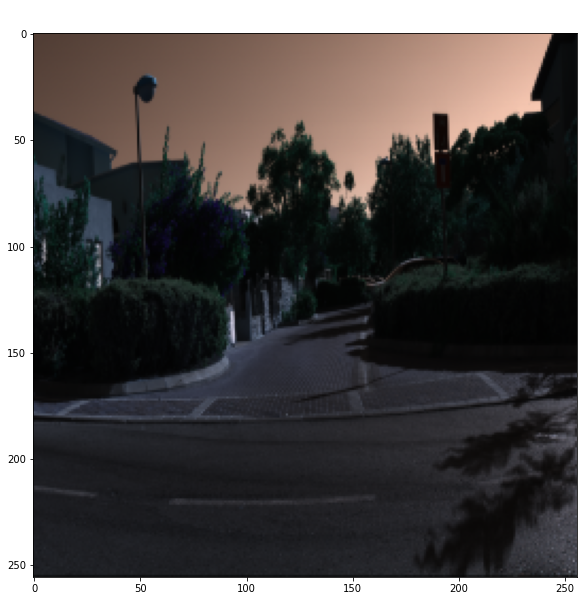

In [ ]:
xx = loadmat('/content/drive/My Drive/Cleaned/validation/BGU_1.mat')
xx = xx['rad']

xx = tf.convert_to_tensor(xx,dtype=tf.float64)
xx = tf.expand_dims(xx,0)
xx = tf.image.resize(xx,(256,256))
xx = xx/tf.math.reduce_max(xx)
xx = xx.numpy()


plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['axes.titlesize'] = 26

fig , (ax1) = plt.subplots(1,1)
ax1.imshow(generated_image[1][:,:,[10,15,20]]/tf.math.reduce_max(generated_image[11][:,:,[10,15,20]]))
ax1.set_title('Measurement')

plt.show()

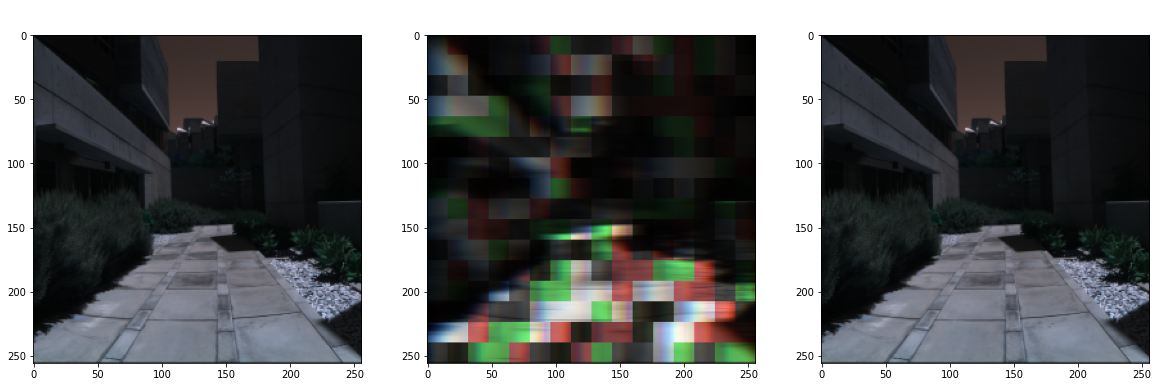

In [ ]:
xx = loadmat('/content/drive/My Drive/Cleaned/validation/BGU_10.mat')
xx = xx['rad']

#imagen de entrada
xx = tf.convert_to_tensor(xx,dtype=tf.float64)
xx = tf.expand_dims(xx,0)
xx = tf.image.resize(xx,(256,256))
xx = xx/tf.math.reduce_max(xx)
xx = xx.numpy()

#measurement
input = tf.transpose(tf.reshape(xx,(1,31*256*256)),(1,0))
y = tf.sparse.sparse_dense_matmul(H_s, tf.cast(input, dtype=tf.float64))
y = tf.sparse.sparse_dense_matmul(tf.sparse.transpose(H_s), y)
ex = tf.reshape(tf.transpose(y,(1,0)),(1,256,256,31))
ex = ex / tf.math.reduce_max(ex)
ex = ex.numpy()

#imagen recuperada


rec = model.predict(xx)

plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['axes.titlesize'] = 26

fig , (ax1, ax2,ax3) = plt.subplots(1,3)
ax1.imshow(xx[0][:,:,[10,15,20]])
ax1.set_title('Imágen Original')
ax2.imshow(ex[0][:,:,[10,15,20]])
ax2.set_title('Measurement')
ax3.imshow(rec[0][:,:,[10,15,20]])
ax3.set_title('Reconstruida')

plt.show()

In [ ]:
rec = rec.squeeze()

In [ ]:
from scipy.io  import savemat
savemat('/content/drive/' + 'reconstruccion.mat',mdict={'predicted': rec})